In [60]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

df = pd.read_csv("cleaned_data_with_region_and_price_per_m2.csv")
print(display(df.head()))

,Unnamed: 0,Property ID,Locality data,Price,Property type,Number of bedrooms,Living area m²,Equipped kitchen,Furnished,Open fire,Terrace surface m²,Garden area m²,Swimming pool,Building condition,Price per m²,Region,Province
0,9333,20135745,8300,999999,apartment,2.0,118.0,0,0,1,NaN,NaN,0,As new,8474.567797,Flanders,West Flanders
1,1737,20206578,4140,999999,house,13.0,778.0,1,0,1,443.0,NaN,0,Good,1285.345758,Wallonia,Liège
2,7967,20135600,8300,999999,apartment,2.0,118.0,0,0,1,NaN,NaN,0,As new,8474.567797,Flanders,West Flanders
3,2563,20234889,1851,999000,house,4.0,345.0,1,1,1,15.0,NaN,0,Good,2895.652174,Flanders,Flemish Brabant
4,5435,20215434,1160,997000,apartment,3.0,144.0,0,0,1,43.0,NaN,0,As new,6923.611111,Brussels,Brussels


None


## Preprocessing
1. First drop irrelevant features.
2. Since dropped the columns for Terrace and Garden area, do not need to impute missing values.
3. Label encode 'Building condition'
3. Turn categorical features into binary/numeric ('house'/'apartment', 'province') - onehot encoder

In [36]:
# Transforming qualitative into numerical. Encoded building condition ranges from 0 - 5:
# ['As new' 'Good' 'To be done up' 'Just renovated' 'To renovate' 'To restore']

label_encoder_property_type = LabelEncoder()
label_encoder_condition = LabelEncoder()
df['Encoded Building Condition'] = label_encoder_condition.fit_transform(df['Building condition'])
display(df.head(20))

,Unnamed: 0,Property ID,Locality data,Price,Property type,Number of bedrooms,Living area m²,Equipped kitchen,Furnished,Open fire,Terrace surface m²,Garden area m²,Swimming pool,Building condition,Price per m²,Region,Province,Encoded Building Condition
0,9333,20135745,8300,999999,apartment,2.0,118.0,0,0,1,NaN,NaN,0,As new,8474.567797,Flanders,West Flanders,0
1,1737,20206578,4140,999999,house,13.0,778.0,1,0,1,443.0,NaN,0,Good,1285.345758,Wallonia,Liège,1
2,7967,20135600,8300,999999,apartment,2.0,118.0,0,0,1,NaN,NaN,0,As new,8474.567797,Flanders,West Flanders,0
3,2563,20234889,1851,999000,house,4.0,345.0,1,1,1,15.0,NaN,0,Good,2895.652174,Flanders,Flemish Brabant,1
4,5435,20215434,1160,997000,apartment,3.0,144.0,0,0,1,43.0,NaN,0,As new,6923.611111,Brussels,Brussels,0
5,1004,20226523,8420,995000,house,4.0,568.0,0,0,1,NaN,NaN,0,Good,1751.760563,Flanders,West Flanders,1
6,2136,20207321,1150,995000,house,5.0,339.0,0,0,1,NaN,NaN,0,As new,2935.103245,Brussels,Brussels,0
7,6077,20238340,1040,995000,apartment,3.0,220.0,0,0,1,25.0,NaN,0,As new,4522.727273,Brussels,Brussels,0
8,2747,20161968,2000,995000,house,5.0,398.0,1,0,1,13.0,78.0,0,Good,2500.000000,Flanders,Antwerp,1
9,8480,10626636,8301,995000,apartment,3.0,100.0,0,0,1,NaN,NaN,0,As new,9950.000000,Flanders,West Flanders,0


In [37]:
# Drop unnecessary columns not needed for the model
df = df.drop(['Property ID', 'Open fire', 'Unnamed: 0', 'Locality data', 'Region', 'Price per m²', 'Terrace surface m²', 'Garden area m²', 'Building condition'], axis=1)
display(df.head(10))

,Price,Property type,Number of bedrooms,Living area m²,Equipped kitchen,Furnished,Swimming pool,Province,Encoded Building Condition
0,999999,apartment,2.0,118.0,0,0,0,West Flanders,0
1,999999,house,13.0,778.0,1,0,0,Liège,1
2,999999,apartment,2.0,118.0,0,0,0,West Flanders,0
3,999000,house,4.0,345.0,1,1,0,Flemish Brabant,1
4,997000,apartment,3.0,144.0,0,0,0,Brussels,0
5,995000,house,4.0,568.0,0,0,0,West Flanders,1
6,995000,house,5.0,339.0,0,0,0,Brussels,0
7,995000,apartment,3.0,220.0,0,0,0,Brussels,0
8,995000,house,5.0,398.0,1,0,0,Antwerp,1
9,995000,apartment,3.0,100.0,0,0,0,West Flanders,0


#### OneHotEncoder

In [38]:
def one_hot_encode_columns(df, columns_to_encode):
    """
    One-hot encode the specified columns in the DataFrame.
    Parameters:
    df (DataFrame): The original DataFrame
    columns_to_encode (list): List of columns to be one-hot encoded
    Returns:
    DataFrame: The DataFrame with the specified columns one-hot encoded and added.
    """
    for column in columns_to_encode:   
        column_data = df[[column]]
        encoder = OneHotEncoder(drop='first', sparse_output=False)
        encoded_data = encoder.fit_transform(column_data) # fit_transform applies the encoder
        encoded_df = pd.DataFrame(encoded_data, columns=encoder.get_feature_names_out([column]))
        df = pd.concat([df, encoded_df], axis=1)
        df = df.drop(column, axis=1)
    return df # return outside the loop to process all columns before returning updated DataFrame
    
columns_to_encode = ['Property type', 'Province']
df = one_hot_encode_columns(df, columns_to_encode) # update the df on each iteration

df.head(10)


,Price,Number of bedrooms,Living area m²,Equipped kitchen,Furnished,Swimming pool,Encoded Building Condition,Property type_house,Province_Brussels,Province_East Flanders,Province_Flemish Brabant,Province_Hainaut,Province_Limburg,Province_Liège,Province_Luxembourg,Province_Namur,Province_Walloon Brabant,Province_West Flanders
0,999999,2.0,118.0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,999999,13.0,778.0,1,0,0,1,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
2,999999,2.0,118.0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,999000,4.0,345.0,1,1,0,1,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,997000,3.0,144.0,0,0,0,0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,995000,4.0,568.0,0,0,0,1,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
6,995000,5.0,339.0,0,0,0,0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,995000,3.0,220.0,0,0,0,0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8,995000,5.0,398.0,1,0,0,1,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9,995000,3.0,100.0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


In [39]:
df.head(10)

,Price,Number of bedrooms,Living area m²,Equipped kitchen,Furnished,Swimming pool,Encoded Building Condition,Property type_house,Province_Brussels,Province_East Flanders,Province_Flemish Brabant,Province_Hainaut,Province_Limburg,Province_Liège,Province_Luxembourg,Province_Namur,Province_Walloon Brabant,Province_West Flanders
0,999999,2.0,118.0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,999999,13.0,778.0,1,0,0,1,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
2,999999,2.0,118.0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,999000,4.0,345.0,1,1,0,1,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,997000,3.0,144.0,0,0,0,0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,995000,4.0,568.0,0,0,0,1,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
6,995000,5.0,339.0,0,0,0,0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,995000,3.0,220.0,0,0,0,0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8,995000,5.0,398.0,1,0,0,1,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9,995000,3.0,100.0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


### Spilt data set

Split your data into train and test.

random_state=41 ensures reproducibility. Will produce the same output, doesnt change the different test and train columns each time you rerun the code

test_size=0.2 means 20% of the data will be used for testing and the other 80% will be used for training.

In [40]:
y = df['Price'] # Target variable
X = df.drop(columns=['Price']) # All other column features in df after dropping the target
X_train, X_test, y_train, y_test = train_test_split(X,y, random_state=41, test_size=0.2) # Get 4 parameters back
print(f"X_train shape: {X_train.shape}")
print(f"X_test shape: {X_test.shape}")

X_train shape: (6684, 17)
X_test shape: (1672, 17)


In [41]:
# Ensure no missing values are present
print(df.isnull().sum())


Price                         0
Number of bedrooms            0
Living area m²                0
Equipped kitchen              0
Furnished                     0
Swimming pool                 0
Encoded Building Condition    0
Property type_house           0
Province_Brussels             0
Province_East Flanders        0
Province_Flemish Brabant      0
Province_Hainaut              0
Province_Limburg              0
Province_Liège                0
Province_Luxembourg           0
Province_Namur                0
Province_Walloon Brabant      0
Province_West Flanders        0
dtype: int64



### Standardize dataset features
Use numpy's mean and standard deviation functions to standardize each feature of the training and testing set. These are `np.mean()` and `np.std()`.

Standardizing is important in models like linear regression, logistic regression, SVM, k-nearest neighbors (KNN), and neural networks as they are sensitive to the scale of the input features. Scale means the range and distribution of values for different features (columns) in your dataset. e.g. Size in sq meters could range from 20-500, while number of rooms might range from 1 to 10.

One reason to use mean and stdev from trained dataset is the test set is meant to represent unseen data. By applying the mean and standard deviation from the training set, you are simulating how the model will perform in a real-world situation, where new data will be standardized based on the parameters of the data the model was trained on.

fit_transform(X_train): Calculates the mean and standard deviation from the training data and applies the transformation to standardize X_train.




In [42]:
scaler = StandardScaler()

X_train_standardized = scaler.fit_transform(X_train)
X_test_standardized = scaler.transform(X_test) # Uses same mean and standard deviation calculated from the training set to transform the test data
X_train_standardized = pd.DataFrame(X_train_standardized, columns=X_train.columns)
X_test_standardized = pd.DataFrame(X_test_standardized, columns=X_test.columns)

print(display(X_train_standardized.head()))
print(display(X_test_standardized.head()))
# Check mean and standard deviation of the training data after scaling
print("Means of standardized features (training set):", X_train_standardized.mean(axis=0).values)
print("Standard deviations of standardized features (training set):", X_train_standardized.std(axis=0).values)



,Number of bedrooms,Living area m²,Equipped kitchen,Furnished,Swimming pool,Encoded Building Condition,Property type_house,Province_Brussels,Province_East Flanders,Province_Flemish Brabant,Province_Hainaut,Province_Limburg,Province_Liège,Province_Luxembourg,Province_Namur,Province_Walloon Brabant,Province_West Flanders
0,1.751085,0.600095,-0.801915,-0.20118,-0.132896,-1.084831,0.977805,-0.484802,1.927091,-0.282808,-0.193404,-0.100625,-0.335987,-0.195887,-0.155598,-0.192987,-0.440694
1,0.154869,-0.424523,-0.801915,-0.20118,-0.132896,-1.084831,0.977805,-0.484802,-0.518917,-0.282808,-0.193404,-0.100625,-0.335987,-0.195887,-0.155598,-0.192987,2.269148
2,-0.643239,-0.467665,1.247015,-0.20118,-0.132896,-0.306742,-1.022699,2.062697,-0.518917,-0.282808,-0.193404,-0.100625,-0.335987,-0.195887,-0.155598,-0.192987,-0.440694
3,2.549193,2.476762,-0.801915,-0.20118,-0.132896,2.027525,0.977805,-0.484802,-0.518917,-0.282808,-0.193404,-0.100625,-0.335987,-0.195887,-0.155598,-0.192987,-0.440694
4,0.952977,0.168677,-0.801915,-0.20118,-0.132896,-0.306742,0.977805,-0.484802,1.927091,-0.282808,-0.193404,-0.100625,-0.335987,-0.195887,-0.155598,-0.192987,-0.440694


None


,Number of bedrooms,Living area m²,Equipped kitchen,Furnished,Swimming pool,Encoded Building Condition,Property type_house,Province_Brussels,Province_East Flanders,Province_Flemish Brabant,Province_Hainaut,Province_Limburg,Province_Liège,Province_Luxembourg,Province_Namur,Province_Walloon Brabant,Province_West Flanders
0,0.154869,0.546167,-0.801915,-0.20118,-0.132896,2.805615,0.977805,-0.484802,-0.518917,-0.282808,-0.193404,-0.100625,2.976308,-0.195887,-0.155598,-0.192987,-0.440694
1,-0.643239,-0.715730,-0.801915,-0.20118,-0.132896,-1.084831,-1.022699,-0.484802,-0.518917,3.535962,-0.193404,-0.100625,-0.335987,-0.195887,-0.155598,-0.192987,-0.440694
2,-0.643239,-0.769657,1.247015,-0.20118,-0.132896,1.249436,-1.022699,-0.484802,-0.518917,-0.282808,-0.193404,-0.100625,-0.335987,-0.195887,-0.155598,-0.192987,-0.440694
3,0.154869,0.006895,1.247015,-0.20118,-0.132896,-0.306742,0.977805,-0.484802,1.927091,-0.282808,-0.193404,-0.100625,-0.335987,-0.195887,-0.155598,-0.192987,-0.440694
4,0.154869,-0.208814,-0.801915,-0.20118,-0.132896,2.805615,-1.022699,-0.484802,-0.518917,-0.282808,-0.193404,-0.100625,2.976308,-0.195887,-0.155598,-0.192987,-0.440694


None
Means of standardized features (training set): [ 1.32881272e-17 -1.47763974e-16  5.42155588e-17  1.43511773e-17
  1.80718529e-17  4.57111574e-17  7.83999503e-17 -1.06305017e-17
  8.50440139e-18  1.91349031e-17  1.59457526e-18 -2.97654048e-17
  7.01613114e-17  3.50806557e-17 -1.62115151e-17  2.12610035e-18
  3.72067561e-17]
Standard deviations of standardized features (training set): [1.00007481 1.00007481 1.00007481 1.00007481 1.00007481 1.00007481
 1.00007481 1.00007481 1.00007481 1.00007481 1.00007481 1.00007481
 1.00007481 1.00007481 1.00007481 1.00007481 1.00007481]


### Load and fit the model

1. Import `LinearRegression` from `sklearn`
2. Create a `regressor` variable and instantiate your `LinearRegression` class.
3. Train your model with `X_train` and `y_train`.
4. Display the score of your model with `X_train` and `y_train`.
5. Use the predict method of your model on your test dataset (`X_test`).
6. Display the score of your model with `X_test` and `y_test`.

R2=1: This means that the model perfectly predicts the target variable. The predictions match the actual values exactly.

R2=0: This means the model does not explain any of the variance in the target variable. It performs as poorly as simply predicting the mean of the target.

Negative R2: This indicates that the model is worse than simply predicting the mean for every observation (which can happen if the model does not fit the data well).

In [43]:
lr = LinearRegression()
# Finds the best fit line on the training model (find m (slope) and c (coefficient, y-intercept)) on training parameters
lr.fit(X_train, y_train) 
c = lr.intercept_ # View the fitted and calculated y-intercept
m = lr.coef_ # View the fitted and calculated slope value
print(m, c)

[  34469.16656875     840.6539433   -19388.71907454   42662.62118892
  104206.37801289  -37636.83394546  -17286.233641     59656.938096
  -19229.94544241   43184.69038748 -129231.81143011  -30572.80270289
 -114992.77121644  -91185.93290892 -120982.75620389   28308.69357438
   28223.61482678]


In [66]:
train_score = lr.score(X_train, y_train)
test_score = lr.score(X_test, y_test)
print(f"Coefficient of determination (R^2) for trained data: {train_score}")
print(f"Coefficient of determination (R^2) for test data: {test_score}")
y_pred = lr.predict(X_test) # Generate predictions from a fitted liner regression model on new unseen data.
print(y_test)
print(y_pred)
lr.score(X_test, y_test)

# Calculate Mean Squared Error and R^2 Score from sklearn.metrics import
mse = mean_squared_error(y_test, y_pred)
root_mse = np.sqrt(mse)
print(f"Root Mean Squared Error: {root_mse}")
r2 = r2_score(y_test, y_pred)
print("Mean Squared Error:", mse)
print("R^2 Score:", r2)

Coefficient of determination (R^2) for trained data: 0.4553198454259427
Coefficient of determination (R^2) for test data: 0.47414283593214024
6526    229000
4330    325000
4739    299900
4151    335000
7497    180000
         ...  
7732    169000
852     649000
3257    385000
141     910000
2511    429000
Name: Price, Length: 1672, dtype: int64
[178326.23352601 409148.42056323 229461.23954833 ... 507408.02342497
 487051.03091175 493108.65882697]
Root Mean Squared Error: 139468.32634044572
Mean Squared Error: 19451414052.20507
R^2 Score: 0.47414283593214024


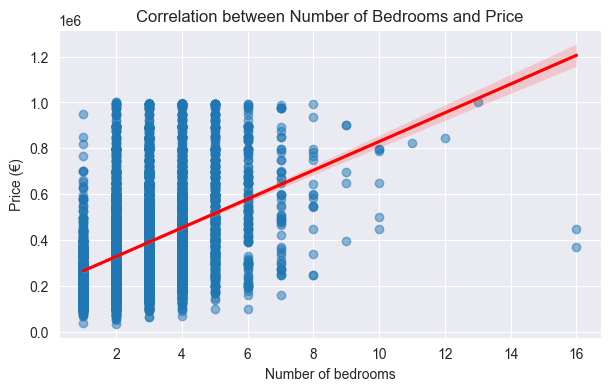

In [63]:
# Scatter plot of 'Number of Bedrooms' vs 'Price'

plt.figure(figsize=(7, 4))
sns.regplot(x='Number of bedrooms', y='Price', data=df, scatter_kws={'alpha': 0.5}, line_kws={'color': 'red'})
plt.xlabel('Number of bedrooms')
plt.ylabel('Price (€)')
plt.title('Correlation between Number of Bedrooms and Price')

plt.show()
